In [15]:
#BÀI 3.2.4
import pandas as pd
import numpy as np
import sklearn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings
df = pd.read_csv("OnlineRetail.csv", encoding='ISO-8859-1')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
86666,543590,22630,DOLLY GIRL LUNCH BOX,2,10-02-2011 11:44,1.95,17377.0,United Kingdom
86667,543590,22587,FELTCRAFT HAIRBAND RED AND BLUE,1,10-02-2011 11:44,0.85,17377.0,United Kingdom
86668,543590,22150,3 STRIPEY MICE FELTCRAFT,2,10-02-2011 11:44,1.95,17377.0,United Kingdom
86669,543590,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,3,10-02-2011 11:44,2.55,17377.0,United Kingdom


In [25]:
# Đọc file dữ liệu (đảm bảo file 'OnlineRetail.csv' nằm cùng thư mục)
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')


# 1. Loại bỏ các dòng không có mã khách hàng
df.dropna(subset=['CustomerID'], inplace=True)


# 2. Loại bỏ các giao dịch trả hàng (Quantity < 0)
df = df[df['Quantity'] > 0]


# 3. Chuyển CustomerID sang kiểu số nguyên
df['CustomerID'] = df['CustomerID'].astype(int)


# 4. Tạo cột Tổng tiền (TotalPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


# 5. Chuyển cột InvoiceDate sang kiểu datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%d-%m-%Y %H:%M")

In [18]:
# Xác định ngày chụp (snapshot_date) là ngày giao dịch cuối cùng + 1 ngày
import datetime as dt
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


# Gom nhóm theo CustomerID để tính Recency, Frequency và Monetary
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                        # Frequency
    'TotalPrice': 'sum'                                            # Monetary
})


# Đổi tên các cột cho dễ hiểu
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)


print(rfm.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           155          1       77183.60
12347            12          4        2205.95
12348            78          3        1487.24
12350           139          1         334.40
12352            91          5        1561.81


In [19]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


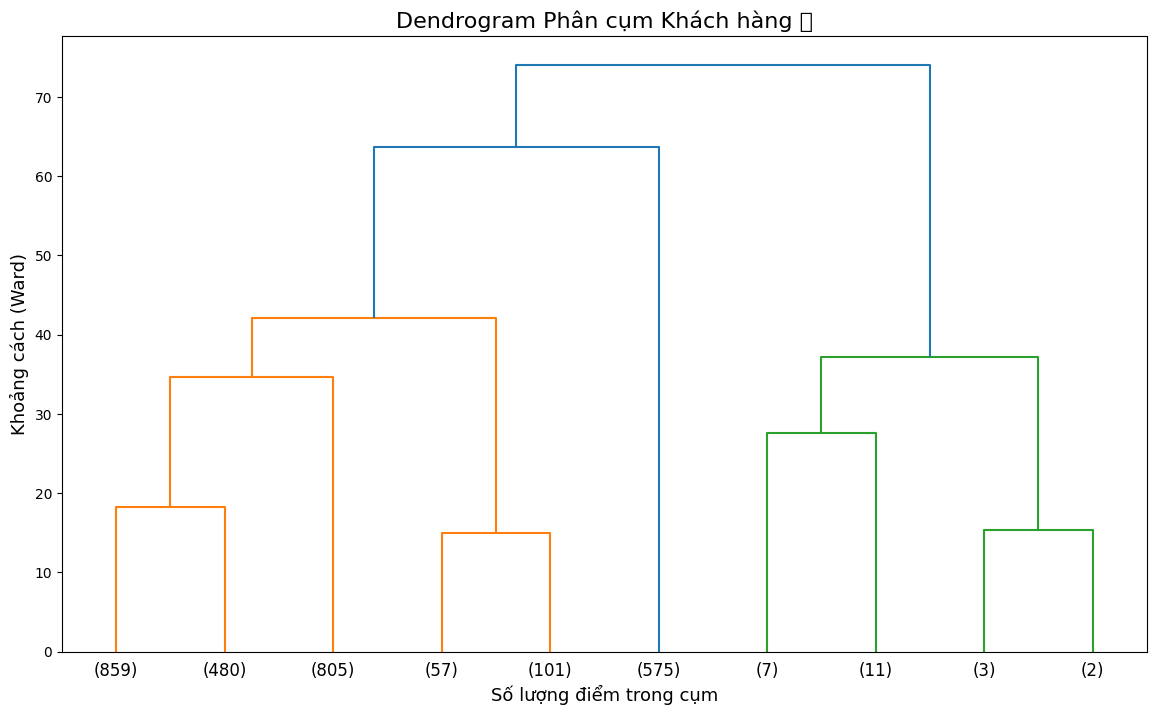

In [20]:
# Tạo ma trận liên kết bằng phương pháp Ward
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster  
linked = linkage(rfm_scaled, method='ward')


# Vẽ biểu đồ Dendrogram
plt.figure(figsize=(14, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='lastp',   # Hiển thị p cụm cuối cùng
           p=10                     # ✅ p=10 là giá trị tối ưu cho dataset này
          )
plt.title('Dendrogram Phân cụm Khách hàng 🌳', fontsize=16)
plt.xlabel('Số lượng điểm trong cụm', fontsize=13)
plt.ylabel('Khoảng cách (Ward)', fontsize=13)
plt.show()

In [21]:
from sklearn.cluster import AgglomerativeClustering
agg_cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = agg_cluster.fit_predict(rfm_scaled)


# Gán nhãn cụm vào bảng RFM
rfm['Cluster'] = labels

In [22]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(2)


print("\n📊 Tóm tắt đặc trưng trung bình của các cụm khách hàng:")
print(cluster_summary)


📊 Tóm tắt đặc trưng trung bình của các cụm khách hàng:
         Recency  Frequency  MonetaryValue
Cluster                                   
0          45.76       3.02        1135.80
1          15.48      31.26       42414.56
2         165.17       1.26         396.63


<Axes: xlabel='Frequency', ylabel='MonetaryValue'>

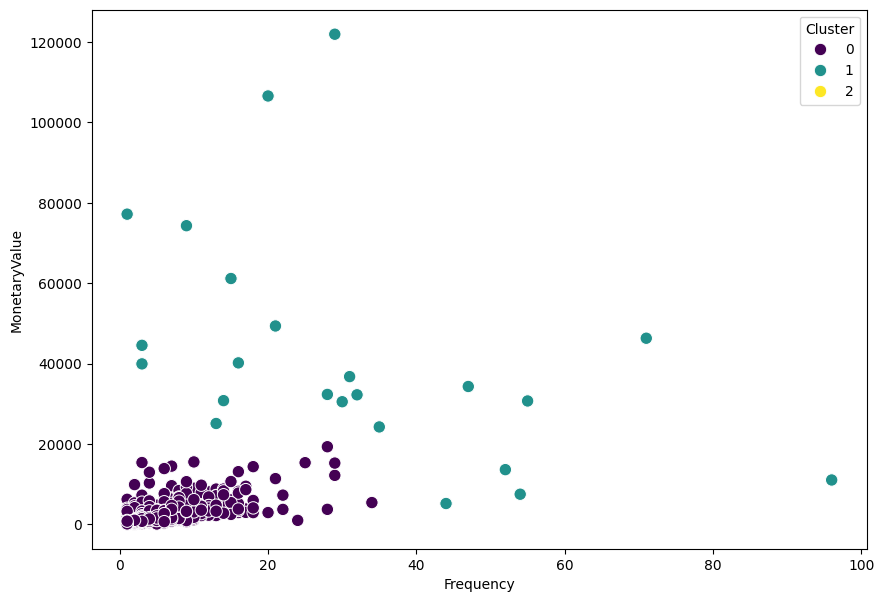

In [23]:
plt.figure(figsize=(10, 7))
import seaborn as sns 
sns.scatterplot(data=rfm, x='Frequency', y='MonetaryValue',
                hue='Cluster', palette='viridis', s=80)

In [24]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(rfm_scaled, labels)
print("\nSilhouette Score cho mô hình phân cụm khách hàng: ", round(sil_score, 3))


Silhouette Score cho mô hình phân cụm khách hàng:  0.494
